In [1]:
#This model includes tempo on-top of KenPom EM difference

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [2]:
tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')


In [3]:
#Cleaning Up Tourney Results

tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'],axis=1)
tourney_result

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325
5,1985,1246,1449
6,1985,1256,1338
7,1985,1260,1233
8,1985,1314,1292
9,1985,1323,1333


In [4]:
#Reading KenPom Values
import os, glob

path = '../input/kenpom/'

all_kenpom = glob.glob(os.path.join(path, "*.csv"))

all_df = []
for f in all_kenpom:
    df = pd.read_csv(f, sep=',')
    df['Season'] = '20' + f.split('/kenpom\summary')[-1]
    all_df.append(df)


merged_df = pd.concat(all_df, ignore_index=True, sort=True)

merged_df['Season'] = merged_df['Season'].str.slice(0,4,1)



kenpom_data = merged_df[['AdjEM','AdjOE','AdjDE','AdjTempo','Season', 'TeamName']]

kenpom_data

,AdjEM,AdjOE,AdjDE,AdjTempo,Season,TeamName
0,34.022000,121.3740,87.3522,73.9016,2002,Duke
1,30.844200,117.4480,86.6033,66.9485,2002,Cincinnati
2,27.788300,118.1000,90.3113,77.6019,2002,Kansas
3,26.853400,118.1510,91.2974,73.3263,2002,Maryland
4,25.717600,115.3870,89.6694,69.5612,2002,Florida
5,24.863700,113.3060,88.4422,65.8584,2002,Oklahoma
6,24.123600,119.9240,95.8006,70.5594,2002,Oregon
7,22.921300,112.5950,89.6736,64.7779,2002,Indiana
8,22.261500,113.2980,91.0361,64.5763,2002,Marquette
9,22.179200,112.5360,90.3566,67.6361,2002,Kentucky


In [5]:
team_names = pd.read_csv('../input/TeamSpellings.csv')

#all_names = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeams.csv')

#all_names = all_names.astype(str)

kenpom_data['TeamName'] = kenpom_data['TeamName'].str.lower()

kenpom_data = kenpom_data.merge(team_names, on='TeamName')

#kenpom_data.to_csv('test2.csv')

kenpom_data = kenpom_data.drop(['TeamName'],axis=1)

kenpom_data



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,AdjEM,AdjOE,AdjDE,AdjTempo,Season,TeamID
0,34.022000,121.3740,87.3522,73.9016,2002,1181
1,22.801800,116.2130,93.4116,71.0877,2003,1181
2,31.727900,120.0270,88.2990,67.6352,2004,1181
3,28.695700,117.4350,88.7397,68.6081,2005,1181
4,28.565600,121.1890,92.6239,69.6792,2006,1181
5,23.643200,112.9730,89.3301,63.6919,2007,1181
6,27.628500,117.4430,89.8149,70.9709,2008,1181
7,25.328400,117.8690,92.5410,65.5211,2009,1181
8,31.548900,119.2960,87.7467,64.9637,2010,1181
9,29.547500,118.6370,89.0891,69.1256,2011,1181


In [6]:
df1 = tourney_result
df2 = kenpom_data

df1['Season']=df1['Season'].astype(int)
df1['WTeamID']=df1['WTeamID'].astype(int)
df1['LTeamID']=df1['LTeamID'].astype(int)

df2['Season']=df2['Season'].astype(int)
df2['TeamID']=df2['TeamID'].astype(int)


#tourney_result = pd.merge(tourney_result, kenpom_data, left_on=['Season','WTeamID'], right_on=['Season','TeamID'], how='left')

#inner join drops years 1985-2001 where KenPom data is not available

df1 = df1.merge(df2,left_on=['Season','WTeamID'],right_on=['Season','TeamID'], how="inner")
df1.rename(columns={'AdjOE':'WAdjOE','AdjDE':'WAdjDE','AdjEM':'WAdjEM','AdjTempo':'WAdjTempo'},inplace=True)
df1 = df1.drop(['TeamID'],axis=1)

df1 = df1.merge(df2,left_on=['Season','LTeamID'],right_on=['Season','TeamID'], how="inner")
df1.rename(columns={'AdjOE':'LAdjOE','AdjDE':'LAdjDE','AdjEM':'LAdjEM','AdjTempo':'LAdjTempo'},inplace=True)
df1 = df1.drop(['TeamID'],axis=1)

indexNames = df1[df1['Season']>2014].index

df1.drop(indexNames,inplace=True)

df1

,Season,WTeamID,LTeamID,WAdjEM,WAdjOE,WAdjDE,WAdjTempo,LAdjEM,LAdjOE,LAdjDE,LAdjTempo
0,2002,1373,1108,-1.73585,100.099,101.8350,66.0443,-8.401770,99.7682,108.1700,72.5438
1,2002,1104,1194,20.01810,114.177,94.1585,67.8101,-3.087320,98.4514,101.5390,69.8592
2,2002,1112,1364,21.81990,119.212,97.3917,71.2261,9.593210,107.6600,98.0668,63.1683
3,2002,1112,1461,21.81990,119.212,97.3917,71.2261,10.851100,108.1900,97.3391,69.0590
4,2002,1181,1457,34.02200,121.374,87.3522,73.9016,-5.043990,97.1532,102.1970,65.6142
5,2002,1181,1323,34.02200,121.374,87.3522,73.9016,17.767800,115.3190,97.5508,68.1446
6,2002,1231,1428,22.92130,112.595,89.6736,64.7779,15.280500,111.4420,96.1611,61.8472
7,2002,1231,1423,22.92130,112.595,89.6736,64.7779,10.717300,106.0320,95.3145,63.0568
8,2002,1231,1181,22.92130,112.595,89.6736,64.7779,34.022000,121.3740,87.3522,73.9016
9,2002,1231,1245,22.92130,112.595,89.6736,64.7779,19.336200,115.8990,96.5628,64.1921


In [7]:
df_win = df1.drop(['Season','WTeamID','LTeamID','WAdjOE','WAdjDE','LAdjOE','LAdjDE'],axis=1)
df_win.rename(columns={'WAdjEM':'AdjEM1', 'LAdjEM':'AdjEM2', 'WAdjTempo':'AdjTempo1', 'LAdjTempo':'AdjTempo2'}, inplace=True)
df_win

,AdjEM1,AdjTempo1,AdjEM2,AdjTempo2
0,-1.73585,66.0443,-8.401770,72.5438
1,20.01810,67.8101,-3.087320,69.8592
2,21.81990,71.2261,9.593210,63.1683
3,21.81990,71.2261,10.851100,69.0590
4,34.02200,73.9016,-5.043990,65.6142
5,34.02200,73.9016,17.767800,68.1446
6,22.92130,64.7779,15.280500,61.8472
7,22.92130,64.7779,10.717300,63.0568
8,22.92130,64.7779,34.022000,73.9016
9,22.92130,64.7779,19.336200,64.1921


In [8]:
df_lose = df_win.copy()
df_lose['AdjEM1'] = df_win['AdjEM2']
df_lose['AdjEM2'] = df_win['AdjEM1']
df_lose['AdjTempo1'] = df_win['AdjTempo2']
df_lose['AdjTempo2'] = df_win['AdjTempo1']
df_lose

,AdjEM1,AdjTempo1,AdjEM2,AdjTempo2
0,-8.401770,72.5438,-1.73585,66.0443
1,-3.087320,69.8592,20.01810,67.8101
2,9.593210,63.1683,21.81990,71.2261
3,10.851100,69.0590,21.81990,71.2261
4,-5.043990,65.6142,34.02200,73.9016
5,17.767800,68.1446,34.02200,73.9016
6,15.280500,61.8472,22.92130,64.7779
7,10.717300,63.0568,22.92130,64.7779
8,34.022000,73.9016,22.92130,64.7779
9,19.336200,64.1921,22.92130,64.7779


In [9]:
df_win['EM_diff'] = df_win['AdjEM1'] - df_win['AdjEM2']
df_lose['EM_diff'] = df_lose['AdjEM1'] - df_lose['AdjEM2']

df_win['result'] = 1
df_lose['result'] = 0

df_final = pd.concat((df_win,df_lose)).reset_index(drop=True)

#df_final

df_final = df_final.drop(['AdjEM1','AdjEM2'],axis=1)
df_final

,AdjTempo1,AdjTempo2,EM_diff,result
0,66.0443,72.5438,6.665920,1
1,67.8101,69.8592,23.105420,1
2,71.2261,63.1683,12.226690,1
3,71.2261,69.0590,10.968800,1
4,73.9016,65.6142,39.065990,1
5,73.9016,68.1446,16.254200,1
6,64.7779,61.8472,7.640800,1
7,64.7779,63.0568,12.204000,1
8,64.7779,73.9016,-11.100700,1
9,64.7779,64.1921,3.585100,1


In [10]:

X_train = df_final.drop('result',axis=1)
y_train = df_final.result
X_train, y_train = shuffle(X_train, y_train)


In [11]:
logreg = LogisticRegression()
params = {'C':np.logspace(start=-5,stop=3,num=9)}
clf = GridSearchCV(logreg,params,scoring='neg_log_loss',refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best log_loss: -0.541, with best C: 0.01


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [12]:
test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
5,2015_1107_1138,0.5,2015,1107,1138
6,2015_1107_1139,0.5,2015,1107,1139
7,2015_1107_1140,0.5,2015,1107,1140
8,2015_1107_1153,0.5,2015,1107,1153
9,2015_1107_1157,0.5,2015,1107,1157


In [13]:
kenpom_data
kenpom_datav2 = kenpom_data.drop(['AdjOE','AdjDE'],axis=1)

test_df = test_df.merge(kenpom_datav2, left_on=['Season','WTeamID'],right_on=['Season','TeamID'],how='left')
test_df.rename(columns={'AdjEM':'AdjEM1','AdjTempo':'AdjTempo1'},inplace=True)
test_df = test_df.drop('TeamID',axis=1)

test_df = test_df.merge(kenpom_datav2, left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
test_df.rename(columns={'AdjEM':'AdjEM2','AdjTempo':'AdjTempo2'},inplace=True)
test_df = test_df.drop('TeamID',axis=1)

test_df


,ID,Pred,Season,WTeamID,LTeamID,AdjEM1,AdjTempo1,AdjEM2,AdjTempo2
0,2015_1107_1112,0.5,2015,1107,1112,3.03231,60.7359,32.314300,65.5943
1,2015_1107_1116,0.5,2015,1107,1116,3.03231,60.7359,16.976700,69.1346
2,2015_1107_1124,0.5,2015,1107,1124,3.03231,60.7359,23.479600,61.2742
3,2015_1107_1125,0.5,2015,1107,1125,3.03231,60.7359,1.495150,66.5706
4,2015_1107_1129,0.5,2015,1107,1129,3.03231,60.7359,13.982400,62.8256
5,2015_1107_1138,0.5,2015,1107,1138,3.03231,60.7359,12.339000,68.4522
6,2015_1107_1139,0.5,2015,1107,1139,3.03231,60.7359,19.626700,63.0408
7,2015_1107_1140,0.5,2015,1107,1140,3.03231,60.7359,17.794700,69.7923
8,2015_1107_1153,0.5,2015,1107,1153,3.03231,60.7359,14.248800,59.2099
9,2015_1107_1157,0.5,2015,1107,1157,3.03231,60.7359,1.621100,63.6717


In [14]:
test_df['EM_diff'] = test_df['AdjEM1'] - test_df['AdjEM2']
test_df = test_df.drop(['ID','Pred','Season','WTeamID','LTeamID','AdjEM1','AdjEM2'],axis=1)
test_df

,AdjTempo1,AdjTempo2,EM_diff
0,60.7359,65.5943,-29.281990
1,60.7359,69.1346,-13.944390
2,60.7359,61.2742,-20.447290
3,60.7359,66.5706,1.537160
4,60.7359,62.8256,-10.950090
5,60.7359,68.4522,-9.306690
6,60.7359,63.0408,-16.594390
7,60.7359,69.7923,-14.762390
8,60.7359,59.2099,-11.216490
9,60.7359,63.6717,1.411210


In [15]:
#test_df['AdjEM1'] = float(test_df['AdjEM1'])
#test_df['AdjTempo1'] = float(test_df['AdjTempo1'])
#test_df['AdjEM2'] = float(test_df['AdjEM2'])
#test_df['AdjTempo2'] = float(test_df['AdjTempo2'])
#test_df['EM_diff'] = float(test_df['EM_diff'])

#pd.isnull(test_df).sum()>0

#np.where(np.isnan(test_df))

#test_df.to_csv('testing.csv')

test_preds = clf.predict_proba(test_df)[:, 1]
test_preds

array([0.02641364, 0.14248773, 0.07708226, ..., 0.58197143, 0.8548909 ,
       0.80885949])

In [16]:
submission_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = test_preds
submission_df

,ID,Pred
0,2015_1107_1112,0.026414
1,2015_1107_1116,0.142488
2,2015_1107_1124,0.077082
3,2015_1107_1125,0.528035
4,2015_1107_1129,0.205488
5,2015_1107_1138,0.227130
6,2015_1107_1139,0.115219
7,2015_1107_1140,0.129865
8,2015_1107_1153,0.207703
9,2015_1107_1157,0.533377


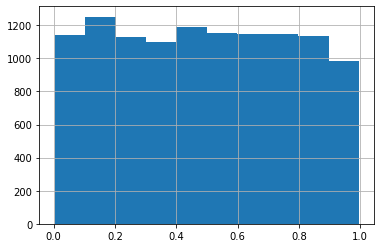

In [17]:
submission_df['Pred'].hist()

In [18]:
submission_df.to_csv('../submissions/submission_v3.csv',index=False)